# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# 🛠 Install Libraries

In [1]:
!pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


# 📚 Import Libraries 

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [3]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'v4'
    comment       = 'unet-efficientnet_b0-320x384'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b0'
    train_bs      = 64
    valid_bs      = train_bs*2
    img_size      = [320, 384]
    epochs        = 16
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    folds         = [0]
    num_classes   = 3
    thr           = 0.40
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ❗ Reproducibility

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 🔨 Utility

In [5]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
#     row['id'] = f'case{case}_day{day}_slice_{slice_}'
    return row

In [6]:
def load_img(path, size=CFG.img_size):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize))
    return img, shape0

def load_imgs(img_paths, size=CFG.img_size):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.float32)
    for i, img_path in enumerate(img_paths):
        if i==0:
            img, shape0 = load_img(img_path, size=size)
        else:
            img, _ = load_img(img_path, size=size)
        img = img.astype('float32') # original is uint16
        mx = np.max(img)
        if mx:
            img/=mx # scale image to [0, 1]
        imgs[..., i]+=img
    return imgs, shape0

def load_msk(path, size=CFG.img_size):
    msk = np.load(path)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((*resize, 3))
    msk = msk.astype('float32')
    msk/=255.0
    return msk

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 📖 Meta Data

In [8]:
BASE_PATH  = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
CKPT_DIR = '/kaggle/input/uwmgi-2-5d-train-pytorch-320x385'

## Test

In [9]:
sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
if not len(sub_df):
    debug = True
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
    sub_df = sub_df[~sub_df.segmentation.isna()][:1000*3]
    sub_df = sub_df.drop(columns=['class','segmentation']).drop_duplicates()
else:
    debug = False
    sub_df = sub_df.drop(columns=['class','predicted']).drop_duplicates()
sub_df = sub_df.progress_apply(get_metadata,axis=1)

100%|██████████| 1429/1429 [00:02<00:00, 629.19it/s]


In [10]:
if debug:
    paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/**/*png',recursive=True)
#     paths = sorted(paths)
else:
    paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/test/**/*png',recursive=True)
#     paths = sorted(paths)
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(path2info, axis=1)
path_df.head()

100%|██████████| 38496/38496 [01:36<00:00, 399.66it/s]


,image_path,height,width,case,day,slice
0,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,6
1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,82
2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,113
3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,76
4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,36,14,125


## Merge Data

In [11]:
test_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')
test_df.head()

,id,case,day,slice,image_path,height,width
0,case123_day20_slice_0065,123,20,65,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
1,case123_day20_slice_0066,123,20,66,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
2,case123_day20_slice_0067,123,20,67,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
3,case123_day20_slice_0068,123,20,68,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
4,case123_day20_slice_0069,123,20,69,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266


## 2.5D MetaData

In [12]:
channels=3
stride=2
for i in range(channels):
    test_df[f'image_path_{i:02}'] = test_df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
test_df['image_paths'] = test_df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
if debug:
    test_df = test_df.sample(frac=1.0)
test_df.image_paths[0]

['/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0067_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0069_266_266_1.50_1.50.png']

# 🍚 Dataset

In [13]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=False, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_paths'].tolist()
        self.ids        = df['id'].tolist()
        if 'msk_path' in df.columns:
            self.msk_paths  = df['mask_path'].tolist()
        else:
            self.msk_paths = None
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        id_       = self.ids[index]
        img = []
        img, shape0 = load_imgs(img_path)
        h, w = shape0
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), id_, h, w

# 🌈 Augmentations

In [14]:
data_transforms = {
    "train": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# 📦 Model


In [15]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔨 Helper

In [16]:
import cupy as cp

def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths):
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx in range(msks.shape[0]):
        msk = msks[idx]
        height = heights[idx].item()
        width = widths[idx].item()
        shape0 = np.array([height, width])
        resize = np.array([320, 384])
        if np.any(shape0!=resize):
            diff = resize - shape0
            pad0 = diff[0]
            pad1 = diff[1]
            pady = [pad0//2, pad0//2 + pad0%2]
            padx = [pad1//2, pad1//2 + pad1%2]
            msk = msk[pady[0]:-pady[1], padx[0]:-padx[1], :]
            msk = msk.reshape((*shape0, 3))
        rle = [None]*3
        for midx in [0, 1, 2]:
            rle[midx] = mask2rle(msk[...,midx])
        pred_strings.extend(rle)
        pred_ids.extend([ids[idx]]*len(rle))
        pred_classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    return pred_strings, pred_ids, pred_classes

# 🔭 Inference

In [17]:
@torch.no_grad()
def infer(model_paths, test_loader, num_log=1, thr=CFG.thr):
    msks = []; imgs = [];
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx, (img, ids, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        size = img.size()
        msk = []
        msk = torch.zeros((size[0], 3, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        for path in model_paths:
            model = load_model(path)
            out   = model(img) # .squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            msk+=out/len(model_paths)
        msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks2rles(msk, ids, heights, widths)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
        if idx<num_log and debug:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            imgs.append(img[::5])
            msks.append(msk[::5])
        del img, msk, out, model, result
        gc.collect()
        torch.cuda.empty_cache()
    return pred_strings, pred_ids, pred_classes, imgs, msks

In [18]:
test_dataset = BuildDataset(test_df, transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                          num_workers=4, shuffle=False, pin_memory=False)
model_paths  = glob(f'{CKPT_DIR}/best_epoch*.bin')
pred_strings, pred_ids, pred_classes, imgs, msks = infer(model_paths, test_loader)

Infer : 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]


# 📈 Visualization

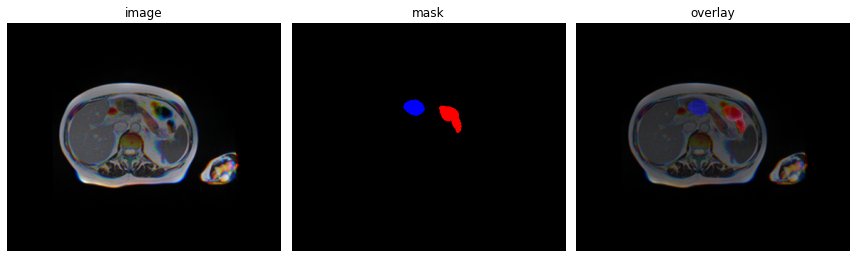

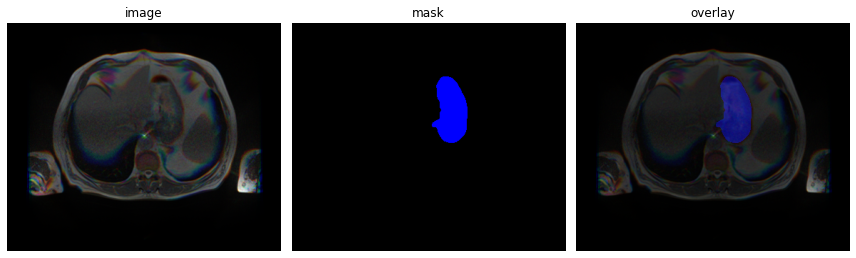

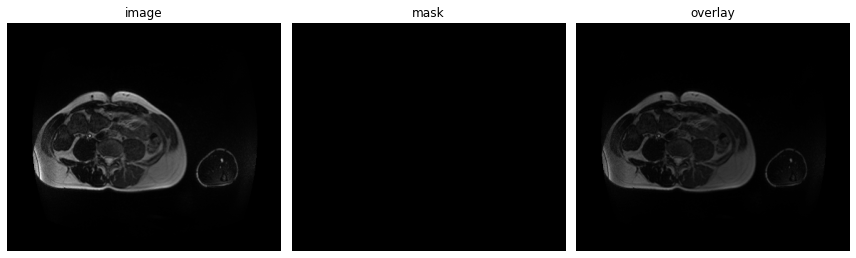

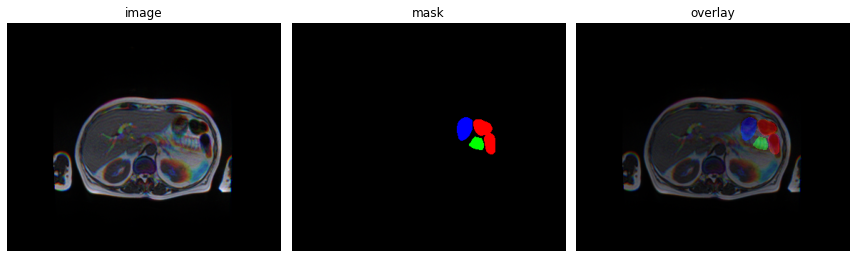

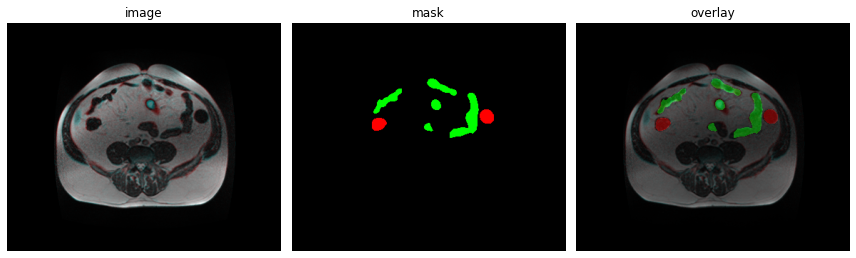

In [19]:
if debug:
    for img, msk in zip(imgs[0][:5], msks[0][:5]):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
        plt.axis('OFF'); plt.title('image')
        plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
        plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()

In [20]:
del imgs, msks
gc.collect()

45569

# 📝 Submission

In [21]:
pred_df = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_strings
})
if not debug:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
    del sub_df['predicted']
else:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    del sub_df['segmentation']
    
sub_df = sub_df.merge(pred_df, on=['id','class'])
sub_df.to_csv('submission.csv',index=False)
display(sub_df.head(5))

,id,class,predicted
0,case123_day20_slice_0065,large_bowel,
1,case123_day20_slice_0065,small_bowel,
2,case123_day20_slice_0065,stomach,
3,case123_day20_slice_0066,large_bowel,
4,case123_day20_slice_0066,small_bowel,
